In [4]:
import sys
import os
sys.path.append(os.path.expanduser('~/workspace/tacotron/'))

import argparse
from hparams import hparams
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import cm
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image
from tacotron.alignment_synthesizer import AlignmentSynthesizer
from tacotron.pml_synthesizer import Configuration, PMLSynthesizer
import tensorflow as tf

In [16]:
training_data_dir = '/media/josh/Store/tacotron-data/163-lj-training'
metadata_filename = os.path.join(training_data_dir, 'test.txt')

cfg = Configuration(16000, 86)
synth = PMLSynthesizer(cfg)
# synth.load(checkpoint_path, hparams, gta=gta, model_name=args.variant)

with open(metadata_filename, encoding='utf-8') as f:
    metadata = [line.strip().split('|') for line in f]
    hours = sum((int(x[2]) for x in metadata)) * hparams.frame_shift_ms / (3600 * 1000)
    print('Loaded metadata for %d examples (%.2f hours)' % (len(metadata), hours))
    
pml_features = [m[3] for m in metadata]
texts = [m[5] for m in metadata]
wav_files = [m[6] for m in metadata]

Loaded metadata for 150 examples (0.27 hours)


In [17]:
import shutil
shutil.copyfile(os.path.join(training_data_dir, 'analysis_synthesis_163', wav_files[TARGET_INDEX]), './HigherDimensional/analysis_synthesis_163.wav')

'./HigherDimensional/analysis_synthesis_163.wav'

In [10]:
FIGSIZE = (10, 6)
TARGET_INDEX = 26
texts[TARGET_INDEX]

'Also the Department requests the sum of one hundred thousand dollars to conduct a detailed feasibility study;'

In [5]:
def show_alignment(alignment, label, ax, cmap=cm.cool, cutoff=220, scale_factor=1, norm=False):
    # normalise the alignment to scale from 0 to 1
    if norm:
        alignment = alignment / np.max(alignment)
    
    # set the background of the axis to black
    ax.set_facecolor('xkcd:black')
    
    cool = cmap(np.arange(cmap.N))
    # Set alpha
    cool[:, -1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    cool = ListedColormap(cool)
    # generate the image
    im_obj = Image.fromarray(np.uint8(cool(alignment) * 255))
    height, width = alignment.shape
    im_obj = im_obj.resize((round(width * scale_factor), height))
    im_obj = np.array(im_obj)[:, :cutoff]
    
    im = ax.imshow(
        im_obj / 255,
        cmap=cmap,
        aspect='auto',
        origin='lower',
        interpolation='none')
    
    patch = mpatches.Patch(color=cool(0.8), label=label)
    
    xstep = 50
    outputs_per_step = 5
    frame_shift = 0.005
    plt.xticks(np.arange(0, 250, step=xstep),
               np.arange(0, 250 * frame_shift * outputs_per_step, step=frame_shift * outputs_per_step * xstep))
    plt.xlabel('Decoder Time (s)')
    plt.ylabel('Encoder Step (character index)')
    plt.tight_layout()
    
    return im, patch

In [11]:
fixed_sentence = texts[TARGET_INDEX]

In [6]:
# reset the graph before we do anything
tf.reset_default_graph()
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=86,spec_type=mcep')
synth = AlignmentSynthesizer()
synth.load('/media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000', hparams, model_name='tacotron_pml', locked_alignments=None)
first_alignment = synth.synthesize(fixed_sentence)  # of shape (encoder_steps, decoder_steps)

# reset the graph after the first synthesise call
tf.reset_default_graph()
synth.load('/media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000', hparams, model_name='tacotron_orig', locked_alignments=None)
second_alignment = synth.synthesize(fixed_sentence)

Constructing model: tacotron_pml
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  430
  decoder out (1 frame):   86
Loading checkpoint: /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000
Constructing model: tacotron_orig
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  400
  decoder out (1 frame):   80
  postnet out:             256
  linear out:              1025
Loading checkpoint: /media/josh/Store/remote-logs/tacotron-lj-500k/model.ckpt-195000
INFO:tens

In [7]:
# reset the graph after the second synthesise call
tf.reset_default_graph()
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=163,spec_type=fwbnd')
synth.load('/media/josh/Store/remote-logs/163-pmlx-lj-150k/model.ckpt-112000', hparams, model_name='tacotron', locked_alignments=None)
third_alignment = synth.synthesize(fixed_sentence)

Constructing model: tacotron
Initialized Tacotron model. Dimensions: 
  Train mode:              False
  GTA mode:                False
  Embedding:               256
  Prenet out:              128
  Encoder out:             256
  Attention out:           256
  Concat attn & out:       512
  Decoder cell out:        256
  Decoder out (5 frames):  815
  Decoder out (1 frame):   163
  Postnet out:             256
  PML out:                 163
Loading checkpoint: /media/josh/Store/remote-logs/163-pmlx-lj-150k/model.ckpt-112000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/163-pmlx-lj-150k/model.ckpt-112000


In [11]:
# reset the graph before we do anything
tf.reset_default_graph()
synth = AlignmentSynthesizer()
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=86,spec_type=mcep')
synth.load('/media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000', hparams, model_name='tacotron_pml_x', locked_alignments=None)
pmlx_alignment = synth.synthesize(fixed_sentence)  # of shape (encoder_steps, decoder_steps)

Constructing model: tacotron_pml_x
Initialized Tacotron model. Dimensions: 
  embedding:               256
  prenet out:              128
  encoder out:             256
  attention out:           256
  concat attn & out:       512
  decoder cell out:        256
  decoder out (5 frames):  430
  decoder out (1 frame):   86
  postnet out:             256
  pml out:                 86
Loading checkpoint: /media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000
INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/pmlx-lj-500k/model.ckpt-131000


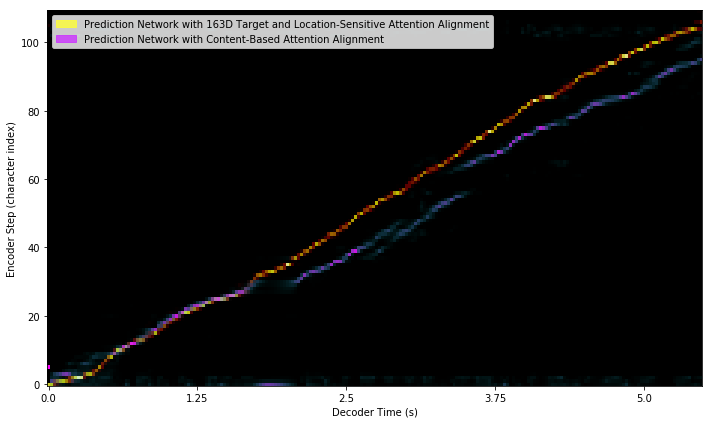

In [29]:
fig, ax = plt.subplots(figsize=FIGSIZE)

# _, taco_pml_patch = show_alignment(first_alignment, 'Tacotron PML Alignment', ax)
# _, taco_patch = show_alignment(second_alignment, 'Tacotron Alignment', ax, cmap=cm.Wistia, scale_factor=12.5 / 5)
_, taco_higher_patch = show_alignment(third_alignment, 'Prediction Network with 163D Target and Location-Sensitive Attention Alignment', ax, cmap=cm.hot)
_, taco_pmlx_patch = show_alignment(pmlx_alignment, 'Prediction Network with Content-Based Attention Alignment', ax, cmap=cm.cool)
ax.legend(handles=[taco_higher_patch, taco_pmlx_patch], loc='upper left')

plt.savefig('./HigherDimensional/HighDimensionAlignment.png', dpi=600)
plt.show()

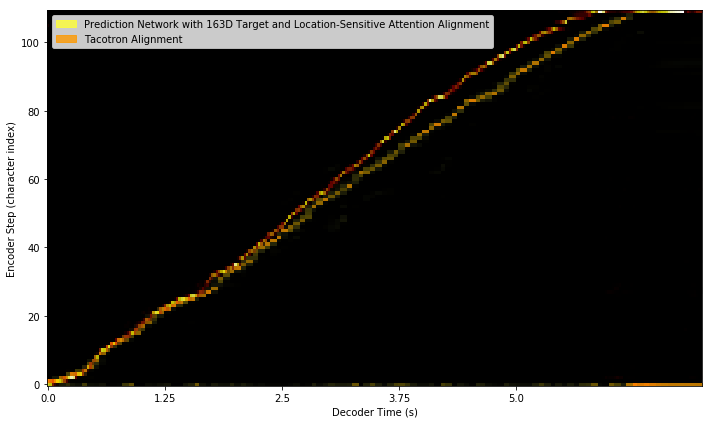

In [30]:
fig, ax = plt.subplots(figsize=FIGSIZE)

# _, taco_pml_patch = show_alignment(first_alignment, 'Tacotron PML Alignment', ax)
_, taco_patch = show_alignment(second_alignment, 'Tacotron Alignment', ax, cmap=cm.Wistia, scale_factor=12.5 / 5, cutoff=280)
_, taco_higher_patch = show_alignment(third_alignment, 'Prediction Network with 163D Target and Location-Sensitive Attention Alignment', ax, cmap=cm.hot, cutoff=280)
# _, taco_pmlx_patch = show_alignment(pmlx_alignment, 'Prediction Network with Content-Based Attention Alignment', ax, cmap=cm.cool)
ax.legend(handles=[taco_higher_patch, taco_patch], loc='upper left')

plt.savefig('./HigherDimensional/HighDimensionAlignmentVsTacotron.png', dpi=600)
plt.show()

In [13]:
from tacotron.pml_synthesizer import Configuration, PMLSynthesizer
from lib import sigproc as sp

# Set up denormalisation parameters for synthesis
mean_path = os.path.expanduser('~/tacotron/LJSpeech-1.1/pml/mean.dat')
std_path = os.path.expanduser('~/tacotron/LJSpeech-1.1/pml/std.dat')
mean_norm = None
std_norm = None

if os.path.isfile(mean_path) and os.path.isfile(std_path):
    mean_norm = np.fromfile(mean_path, 'float32')
    std_norm = np.fromfile(std_path, 'float32')

# reset the graph before we do anything
tf.reset_default_graph()
cfg = Configuration(16000, 163)
pml_synth = PMLSynthesizer(cfg)
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=163,spec_type=fwbnd')
pml_synth.load('/media/josh/Store/remote-logs/163-pmlx-lj-150k/model.ckpt-112000', hparams, model_name='tacotron')
wav_outputs = pml_synth.synthesize([fixed_sentence], to_wav=True, mean_norm=mean_norm, std_norm=std_norm, spec_type=hparams.spec_type, pp_mcep=True)

INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/163-pmlx-lj-150k/model.ckpt-112000
    Forcing binary noise mask


In [14]:
from util import audio
wav = np.copy(wav_outputs[0])
print(len(wav))
wav = wav[:int(16000*5.85)]
sp.wavwrite('./HigherDimensional/163_taco_pml_x.wav', wav, 16000, norm_max_ifneeded=True)

319920


In [77]:
# reset the graph before we do anything
tf.reset_default_graph()
cfg = Configuration(16000, 86)
pml_synth = PMLSynthesizer(cfg)
hparams.parse('sample_rate=16000,frame_length_ms=20,frame_shift_ms=5,pml_dimension=86,spec_type=mcep')
pml_synth.load('/media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000', hparams, model_name='tacotron_pml')
pml_wav_outputs = pml_synth.synthesize([fixed_sentence], to_wav=True)

INFO:tensorflow:Restoring parameters from /media/josh/Store/remote-logs/tacotron-lj-pml-500k/model.ckpt-352000


/home/josh/workspace/tacotron/lib/pulsemodel/synthesis.py:119: UserWarning: 



  warnings.warn('\n\nWARNING: The maximum window length ({}) is bigger than the DFT length ({}). Please, increase the DFT length of your spectral features (the second dimension) or check if the f0 curve has extremly low values and try to clip them to higher values (at least higher than 50Hz). The f0 curve has been clipped to {}Hz.\n\n'.format(winlenmax, dftlen, winnbper*fs/float(dftlen))) # pragma: no cover


    Forcing binary noise mask


In [78]:
wav = pml_wav_outputs[0]
wav = wav[:audio.find_endpoint(wav)]
sp.wavwrite('./TacotronAlignment/taco_pml.wav', wav, 16000, norm_max_ifneeded=True)